# VCT Data Mining
---


## Setup

In [ ]:
%pip install ujson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.1 MB/s eta 0:00:00


In [ ]:
  for p in second_event['configuration']['players']:
      self.players[p['player_id']['value']].update_vec('AGENT', requests.get(f'https://valorant-api.com/v1/weapons/{p['selectedAgent']['fallback']['guid']}'))

SyntaxError: f-string: unmatched '[' (<ipython-input-2-0c629b4160bf>, line 2)

In [ ]:
import requests
import gzip
import shutil
import time
import os
import logging
import sys
import os.path
import requests
import threading
import ujson as json
from collections import deque
from io import BytesIO
from enum import Enum, auto
from tqdm.notebook import tqdm
from os import listdir

In [ ]:
import pandas as pd
import numpy as np
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

## Downloading Data

This step isn't always necessary but usually is
because python is downloading this data to the local instance, the files will get erased on instance termination after a certain amount of time of inactivity.

If you open up the file explorer and the file `/content/vct-international/` is not there then this section needs to be run.

In [ ]:
S3_BUCKET_URL = "https://vcthackathon-data.s3.us-west-2.amazonaws.com"

# (game-changers, vct-international, vct-challengers)
LEAGUE = "vct-international"

# (2022, 2023, 2024)
YEAR = 2024

In [ ]:
def download_gzip_and_write_to_json(file_name):
    if os.path.isfile(f"{file_name}.json"):
        return False

    remote_file = f"{S3_BUCKET_URL}/{file_name}.json.gz"
    response = requests.get(remote_file, stream=True)

    if response.status_code == 200:
        gzip_bytes = BytesIO(response.content)
        with gzip.GzipFile(fileobj=gzip_bytes, mode="rb") as gzipped_file:
            with open(f"{file_name}.json", 'wb') as output_file:
                shutil.copyfileobj(gzipped_file, output_file)
        return True
    elif response.status_code == 404:
        # Ignore
        return False
    else:
        print(response)
        print(f"Failed to download {file_name}")
        return False


def download_esports_files():
    print(f"Downloading esports files for {LEAGUE}...")
    directory = f"{LEAGUE}/esports-data"

    if not os.path.exists(directory):
        os.makedirs(directory)

    esports_data_files = ["leagues", "tournaments",
                          "players", "teams", "mapping_data"]
    for file_name in tqdm(esports_data_files):
        download_gzip_and_write_to_json(f"{directory}/{file_name}")

    print("Done downloading esports files")


def download_games():
    print(f"Downloading game files for {LEAGUE}...")

    local_mapping_file = f"{LEAGUE}/esports-data/mapping_data.json"
    with open(local_mapping_file, "r") as json_file:
        mappings_data = json.load(json_file)

    local_directory = f"{LEAGUE}/games/{YEAR}"
    if not os.path.exists(local_directory):
        os.makedirs(local_directory)

    game_counter = 0

    for esports_game in tqdm(mappings_data):
        s3_game_file = f"{LEAGUE}/games/{YEAR}/{esports_game['platformGameId']}"

        response = download_gzip_and_write_to_json(s3_game_file)

        if (response == True):
            game_counter += 1

    print("Done downloading game files")


In [ ]:
download_esports_files()
download_games()

  0%|          | 0/5 [00:00<?, ?it/s]

Done downloading esports files


  0%|          | 0/1742 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Import Esports Metadata and Mappings

In [ ]:
with open(f'/content/{LEAGUE}/esports-data/players.json', 'r') as f:
    player_df = pd.DataFrame(json.load(f))


NameError: name 'LEAGUE' is not defined

In [ ]:
player_df.head()

id   handle  first_name  last_name  status  \
0  106230271915475632    Derke      Nikita   Sirmitev  active   
1  106651762097869967      Nbs    Laurynas  Kisielius  active   
2  106230373601204025   sScary  Nutchaphon    Matarat  active   
3  106732694881302524   SKYLEN        Asil     Yalçın  active   
4  107735301889701087  Dreamas     Aurimas  Zablockis  active   

                                           photo_url        home_team_id  \
0                                               None  105680972836508184   
1  http://static.lolesports.com/players/162737673...  105830917166593765   
2  http://static.lolesports.com/players/162763658...  105749956224935810   
3  http://static.lolesports.com/players/162861167...  106511417404947629   
4  http://static.lolesports.com/players/164391023...  107735250232004550   

             created_at            updated_at  
0  2021-05-13T22:37:14Z  2021-10-07T10:36:07Z  
1  2021-08-11T07:47:36Z  2021-11-17T18:59:01Z  
2  2021-07-30T09:16:30Z  2022-02-08T09:51:14Z  
3  2021-08-10T16:10:25Z  2021-09-30T15:36:30Z  
4  2022-05-10T13:09:39Z  2022-05-10T13:10:02Z

In [ ]:
mapping_df.head()

platformGameId       esportsGameId  \
0  val:cb611626-2910-46d3-8678-6501bf317f9f  109711321499314292   
1  val:c1514574-4ba4-4ad3-b5ef-dbfef9976946  108871629798741440   
2  val:1db2b321-85bd-4c8c-9ec8-8063e869119f  110551570692873336   
3  val:44f65f2d-1de9-43da-8df3-c543ef0ac5a8  108871676165986748   
4  val:093dcb1f-0350-4c44-aecb-c07972bb8da3  109999128958790492   

         tournamentId                                        teamMapping  \
0  109711321498527756  {'18': '107722603442258744', '19': '1058309042...   
1  108871629797692793  {'16': '105680972836508184', '17': '1057480379...   
2  110551570691955817  {'20': '108696151689107350', '21': '1058309042...   
3  108871629797692793  {'17': '107795656627193642', '18': '1077729157...   
4  109999128956889858  {'21': '109710990829217937', '22': '1056653782...   

                                  participantMapping  
0  {'1': '106651749419114537', '2': '106651802407...  
1  {'1': '106525489805459472', '2': '108273989413...  
2  {'1': '106651749419114537', '2': '106651802407...  
3  {'1': '106525473804840689', '2': '106525472657...  
4  {'1': '107786690677632484', '2': '108329605365...

In [ ]:
team_df.head()

id acronym      home_league_id  \
0  109710990829217937     TAL  109551178413356399   
1  105680883461219195      TL  106109559530232966   
2  107739366448281763      S1  106109559530232966   
3  105680908693496715     FPX  106109559530232966   
4  107735185441106189     BBL  106109559530232966   

                                       dark_logo_url  \
0  http://static.lolesports.com/teams/16740568587...   
1  http://static.lolesports.com/teams/16372525869...   
2  http://static.lolesports.com/teams/16443096761...   
3  http://static.lolesports.com/teams/16445424855...   
4  http://static.lolesports.com/teams/16439084601...   

                                      light_logo_url             slug  \
0  http://static.lolesports.com/teams/16740568587...    talon-esports   
1  http://static.lolesports.com/teams/16372525869...      team-liquid   
2  http://static.lolesports.com/teams/16443096761...       sector-one   
3  http://static.lolesports.com/teams/16445424855...  funplus-phoenix   
4  http://static.lolesports.com/teams/16439084601...              bbl   

              name  
0    Talon Esports  
1      Team Liquid  
2       Sector One  
3  FunPlus Phoenix  
4              BBL

In [ ]:
tournament_df.head()

id     status           league_id        time_zone  \
0  109710937834457925  published  109551178413356399          Etc/UTC   
1  112053399716844250  published  109940824119741550  Europe/Sarajevo   
2  108517568479631144  published  109940824119741550          Etc/UTC   
3  107997085398196447  published  109940824119741550          Etc/UTC   
4  106868306782316745  published  109940824119741550          Etc/UTC   

                        name  
0        lock_in_brazil_2023  
1  vct_masters_shanghai_2024  
2     masters_2_2022_stage_1  
3     masters_1_2022_stage_1  
4                   stage_03

In [ ]:
league_df.head()

league_id region  \
0  109940824119741550   INTL   
1  109974804058058602   INTL   
2  109551178413356399   INTL   
3  106109559530232966   INTL   
4  111691194187846945     CN   

                                       dark_logo_url  \
0  http://static.lolesports.com/leagues/168526311...   
1  http://static.lolesports.com/leagues/167844792...   
2  http://static.lolesports.com/leagues/167161831...   
3  http://static.lolesports.com/leagues/167872405...   
4  http://static.lolesports.com/leagues/170427236...   

                                      light_logo_url         name         slug  
0  http://static.lolesports.com/leagues/168526311...  vct_masters  vct_masters  
1  http://static.lolesports.com/leagues/167956347...  vct_pacific  vct_pacific  
2  http://static.lolesports.com/leagues/167161831...  vct_lock_in  vct_lock_in  
3  http://static.lolesports.com/leagues/167956345...     vct_emea     vct_emea  
4  http://static.lolesports.com/leagues/170427236...    vct_china    vct_china

## Set up data structures

In [ ]:
logging.basicConfig(
    format='{asctime} [{levelname}] {message}',
    style="{",
    datefmt="%H:%M",
    level=logging.CRITICAL,
    force=True
)

NameError: name 'logging' is not defined

In [ ]:
mutex = threading.Lock()

player_bank = dict()

In [ ]:
class Map(Enum):
    ABYSS = auto()
    ASCENT = auto()
    BIND = auto()
    BREEZE = auto()
    FRACTURE = auto()
    HAVEN = auto()
    ICEBOX = auto()
    LOTUS = auto()
    PEARL = auto()
    SPLIT = auto()
    SUNSET = auto()

maps = {
    "Infinity": Map.ABYSS,
    "Ascent": Map.ASCENT,
    "Duality": Map.BIND,
    "Foxtrot": Map.BREEZE,
    "Canyon": Map.FRACTURE,
    "Triad": Map.HAVEN,
    "Port": Map.ICEBOX,
    "Jam": Map.LOTUS,
    "Pitt": Map.PEARL,
    "Bonsai": Map.SPLIT,
    "Juliett": Map.SUNSET,
}

class RoundVec(Enum):
    ROUND_NUMBER = 0#
    OUTCOME = auto()#
    SIDE = auto()#
    KILLS = auto()#
    DEATHS = auto()#
    ASSISTS = auto()#
    COMBAT_SCORE = auto()#
    ####################################
    # Critical section, do not reorder
    ####################################
    KILLS_STINGER = auto()#
    KILLS_BUCKY = auto()#
    KILLS_JUDGE = auto()#
    KILLS_SPECTRE = auto()#
    KILLS_BULLDOG = auto()#
    KILLS_GUARDIAN = auto()#
    KILLS_PHANTOM = auto()#
    KILLS_VANDAL = auto()#
    KILLS_MARSHAL = auto()#
    KILLS_OUTLAW = auto()#
    KILLS_OPERATOR = auto()#
    KILLS_ARES = auto()#
    KILLS_ODIN = auto()#
    KILLS_CLASSIC = auto()#
    KILLS_SHORTY = auto()#
    KILLS_FRENZY = auto()#
    KILLS_GHOST = auto()#
    KILLS_SHERIFF = auto()#
    KILLS_MELEE = auto()#
    ####################################
    # End of critical section
    ####################################
    TIME_ALIVE = auto()#
    DEAD = auto()#
    DAMAGE_TAKEN = auto()#
    DAMAGE_DONE = auto()#
    SPIKE_CARRY_PERCENT = auto()#
    SPIKE_PLANT = auto()#
    # TODO: map score
    # TODO: win type
    # TODO: abilities

class Weapon(Enum):
    STINGER = RoundVec.KILLS_STINGER.value
    BUCKY = auto()
    JUDGE = auto()
    SPECTRE = auto()
    BULLDOG = auto()
    GUARDIAN = auto()
    PHANTOM = auto()
    VANDAL = auto()
    MARSHAL = auto()
    OUTLAW = auto()
    OPERATOR = auto()
    ARES = auto()
    ODIN = auto()
    CLASSIC = auto()
    SHORTY = auto()
    FRENZY = auto()
    GHOST = auto()
    SHERIFF = auto()
    MELEE = auto()


In [ ]:
class PlayerRound:
    def __init__(self, game_id, player_id, map):
        # TODO: add abilities, player killed data, more damage data
        self.game_id = game_id
        self.player_id = player_id
        self.map = map
        self.vec = [0] * len(RoundVec)

    def update_vec(self, idx, val):
        self.vec[idx] = val

    def add_vec(self, idx, i):
        self.vec[idx] += i

    def get_vec(self, idx):
        return self.vec[idx]

class PlayerGame:
    def __init__(self, p):
        self.player_id = p
        self.rounds = list()
        self.vec = None

    def new_round(self, game_id, player_id, map):
        self.rounds.append(PlayerRound(game_id, player_id, map))

    def update_current_round(self, idx, val):
        self.rounds[-1].update_vec(idx, val)

    def add_current_round(self, idx, i):
        self.rounds[-1].add_vec(idx, i)

    def get_current_round_val(self, idx):
        return self.rounds[-1].get_vec(idx)

    def calculate_game_vec(self):
        round_vecs = map(lambda x: x.vec, self.rounds)
        game_vec = map(lambda x: x/float(len(self.rounds)), map(sum, zip(*round_vecs)))
        self.vec = list(game_vec)
        self.vec[RoundVec.ROUND_NUMBER.value] = max([r.vec[RoundVec.ROUND_NUMBER.value] for r in self.rounds])

        mutex.acquire()
        if self.player_id not in player_bank:
            player_bank[self.player_id] = Player(self.player_id)
        player_bank[self.player_id].add_game(self)
        mutex.release()

class Player:
    def __init__(self, p):
        self.player_id = p
        self.games = list()
        self.vec = None

    def add_game(self, game):
        self.games.append(game)

    def calculate_player_vec(self):
        game_vecs = map(lambda x: x.vec, self.games)
        player_vec = map(lambda x: x/float(len(self.games)), map(sum, zip(*game_vecs)))
        self.vec = list(player_vec)

class Game:
    def _process_event(self, event):
        if 'snapshot' in event:
            return

        # side, round number
        if 'roundStarted' in event:
            e = event['roundStarted']
            logging.debug(f'Round started {e}')

            self._processing_round = True
            self._curr_round_start_time = float(event['metadata']['eventTime']['omittingPauses'][:-1])
            attacking_team = str(e['spikeMode']['attackingTeam']['value'])
            for p in self.players:
                self.players[p].new_round(self.game_id, p, self.map)
                # Set current round number
                self.players[p].update_current_round(RoundVec.ROUND_NUMBER.value, e['roundNumber'])

                # Set side
                if int(p) in self.teams[attacking_team]['players']:
                    self.players[p].update_current_round(RoundVec.SIDE.value, 1)
                else:
                    self.players[p].update_current_round(RoundVec.SIDE.value, -1)
            return

        # Skip processing if not inside of a round
        if not self._processing_round:
            return

        cur_time = float(event['metadata']['eventTime']['omittingPauses'][:-1])

        # damage receive, damage dealt
        if 'damageEvent' in event:
            e = event['damageEvent']
            logging.debug(f'Damage Event {e}')

            # Set damage dealt
            if 'causerId' in e:
                causer = str(e['causerId']['value'])
                self.players[causer].add_current_round(RoundVec.DAMAGE_DONE.value, e['damageAmount'])

            # Set damage received
            victim = str(e['victimId']['value'])
            self.players[victim].add_current_round(RoundVec.DAMAGE_TAKEN.value, e['damageAmount'])

            return

        # death flag, weapon kill, time alive, kills, deaths, asissts,
        if 'playerDied' in event:
            e = event['playerDied']
            time_stamp = float(event['metadata']['eventTime']['omittingPauses'][:-1])
            logging.debug(f'Player Died {e}')

            # Set death flag and death counter
            dead_player = str(e['deceasedId']['value'])
            self.players[dead_player].update_current_round(RoundVec.DEAD.value, 1)
            self.players[dead_player].add_current_round(RoundVec.DEATHS.value, 1)

            # Set time alive
            time_alive = time_stamp - self._curr_round_start_time
            self.players[dead_player].update_current_round(RoundVec.TIME_ALIVE.value, time_alive)

            # Update weapon kill tracker and kill counter
            killer = str(e['killerId']['value'])
            self.players[killer].add_current_round(RoundVec.KILLS.value, 1)
            if 'weapon' in e:
                weapon_guid = e['weapon']['fallback']['guid']
                if weapon_guid == "":
                    self.players[killer].add_current_round(Weapon.MELEE.value, 1)
                else:
                    g = requests.get(f'https://valorant-api.com/v1/weapons/{weapon_guid}')
                    Weapon[g.json()['data']['displayName'].upper()]
                    self.players[killer].add_current_round(Weapon[g.json()['data']['displayName'].upper()].value, 1)

            # Update assist counter
            if 'assistants' in e:
                for a in e['assistants']:
                    assister = str(a['assistantId']['value'])
                    self.players[assister].add_current_round(RoundVec.ASSISTS.value, 1)
            return

        # spike plant, spike carry time, spike defuse
        if 'spikeStatus' in event:
            e = event['spikeStatus']
            logging.debug(f'Spike Status {e}')

            # Set spike plant flag and update spike carry time and spike defuse flag
            if e['status'] == "IN_HANDS" and 'carrier' in e:
                if not 'carrier' in e:
                    logging.warning("SPIKE IN_HANDS event with no carrier found")
                else:
                    self._curr_spike_carrier = str(e['carrier']['value'])
                self._curr_spike_pickup_stamp = float(event['metadata']['eventTime']['omittingPauses'][:-1])
            elif e['status'] == "PLANTED":
                self.players[self._curr_spike_carrier].update_current_round(RoundVec.SPIKE_PLANT.value, 1)
                self.players[self._curr_spike_carrier].add_current_round(RoundVec.SPIKE_CARRY_PERCENT.value, cur_time - self._curr_spike_pickup_stamp)
            elif e['status'] == "ON_GROUND":
                self.players[self._curr_spike_carrier].add_current_round(RoundVec.SPIKE_CARRY_PERCENT.value, cur_time - self._curr_spike_pickup_stamp)

            return

        # combat score, outcome, time alive, noramlize spike carry time
        if 'roundDecided' in event:
            e = event['roundDecided']
            logging.debug(f'Round Decided {e}')

            round_length = cur_time - self._curr_round_start_time
            winning_team = str(e['result']['winningTeam']['value'])
            for p in self.players:
                # Set outcome
                if int(p) in self.teams[winning_team]['players']:
                    self.players[p].update_current_round(RoundVec.OUTCOME.value, 1)
                else:
                    self.players[p].update_current_round(RoundVec.OUTCOME.value, -1)

                # Set time alive
                if self.players[p].get_current_round_val(RoundVec.DEAD.value) == 0:
                    self.players[p].add_current_round(RoundVec.TIME_ALIVE.value, round_length)

                # Normalize spike time
                spike_time = self.players[p].get_current_round_val(RoundVec.SPIKE_CARRY_PERCENT.value)
                self.players[p].update_current_round(RoundVec.SPIKE_CARRY_PERCENT.value, spike_time / round_length)


            round_end_stamp = float(event['metadata']['eventTime']['omittingPauses'][:-1])
            while 'snapshot' not in event:
                event = self.event_feed.popleft()

            e = event['snapshot']

            # Set combat score
            for p in e['players']:
                player = str(p['playerId']['value'])
                self.players[player].update_current_round(RoundVec.COMBAT_SCORE.value, p['scores']['combatScore']['roundScore'])

            self._processing_round = False
            self._curr_round_start_time = None
            self._curr_spike_carrier = None
            self._curr_spike_pickup_stamp = None
            self._curr_round_start_time = None
            return


    def __init__(self, file):
        assert(os.path.isfile(file))
        self.file = file
        self.players = dict()
        self.teams = dict()
        self._curr_round_start_time = None
        self._curr_spike_carrier = None
        self._curr_spike_pickup_stamp = None
        self._curr_round_start_time = None
        self._processing_round = False

        logging.critical(f"Reading game {self.file.split('/')[-1]}")
        with open(self.file, 'r') as f:
            # TODO: look into msgspec or similar instead of native json parsing, takes like 10-20 sec to load a game
            j = json.load(f)
        logging.info("Done reading json")

        self.event_feed = deque(j)

        first_event = self.event_feed.popleft()

        self.game_id = first_event['platformGameId']

        players = mapping_df.loc[mapping_df['platformGameId'] == self.game_id, 'participantMapping'].values[0]
        for i, p in enumerate(players.values()):
            self.players[str(i+1)] = PlayerGame(p)

        second_event = self.event_feed.popleft()

        self.map = maps[second_event['configuration']['selectedMap']['fallback']['displayName']]

        teamid = str(second_event['configuration']['teams'][0]['teamId']['value'])
        self.teams[teamid] = dict()
        self.teams[teamid]['players'] = [p['value'] for p in second_event['configuration']['teams'][0]['playersInTeam']]
        self.teams[teamid]['name'] = team_df.iloc[second_event['configuration']['teams'][0]['teamId']['value']]['slug']

        teamid = str(second_event['configuration']['teams'][1]['teamId']['value'])
        self.teams[teamid] = dict()
        self.teams[teamid]['players'] = [p['value'] for p in second_event['configuration']['teams'][1]['playersInTeam']]
        self.teams[teamid]['name'] = team_df.iloc[second_event['configuration']['teams'][1]['teamId']['value']]['slug']

        # ingest events
        logging.info("Ingesting events...")
        with tqdm(total=len(self.event_feed)) as pbar:
            while len(self.event_feed) != 0:
                start_len = len(self.event_feed)
                current_event = self.event_feed.popleft()
                self._process_event(current_event)
                pbar.update(start_len - len(self.event_feed))
        logging.info("Done ingesting events")

        # ingestion post processing
        logging.info("Processing data...")
        for p in tqdm(self.players):
            self.players[p].calculate_game_vec()
        logging.info("Done processing data")


## Data Serialization
This takes a long time, ~30 sec per game

#### One shot test

In [ ]:
player_bank.clear()
temp = Game('/content/vct-international/games/2022/val:c9d7acfc-7a68-4fc2-a22c-60ccc69d99a9.json')
for p in temp.players.values():
    print(p.vec)

03:24 [CRITICAL] Reading game val:c9d7acfc-7a68-4fc2-a22c-60ccc69d99a9.json


  0%|          | 0/6065 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[17, -0.5294117647058824, -0.4117647058823529, 0.47058823529411764, 0.8235294117647058, 0.23529411764705882, 120.47058823529412, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.47058823529411764, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 121.65064705882357, 0.8235294117647058, 105.17639394117647, 52.60076769411765, 0.10907968683425874, 0.058823529411764705]
[17, -0.5294117647058824, -0.4117647058823529, 0.7058823529411765, 0.9411764705882353, 0.23529411764705882, 243.1764705882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23529411764705882, 0.11764705882352941, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29411764705882354, 0.058823529411764705, 0.0, 0.0, 114.72282352941177, 0.9411764705882353, 172.0588236182353, 135.0744311082353, 0.0031010519120495267, 0.0]
[17, -0.5294117647058824, -0.4117647058823529, 0.7647058823529411, 0.9411764705882353, 0.17647058823529413, 229.76470588235293, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.35294117647058826, 0.11764705882352941, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.058

#### Linear Processing

In [ ]:
player_bank.clear()
game_files = listdir(f"{LEAGUE}/games/{YEAR}")
for g in tqdm(game_files):
    _ = Game(f"{LEAGUE}/games/{YEAR}/{g}")

  0%|          | 0/154 [00:00<?, ?it/s]

NameError: name 'Game' is not defined

### Thread Pool Processing

In [ ]:
player_bank.clear()
game_files = deque(listdir(f"{LEAGUE}/games/{YEAR}"))
#temp_list = list(range(10))
#game_files = deque(temp_list)

def process_games():
    try:
        while True:
            target_game_file = game_files.popleft()
            _ = Game(f"{LEAGUE}/games/{YEAR}/{target_game_file}")
    except:
        return

num_processes = 2
pool = [threading.Thread(target=process_games) for _ in range(num_processes)]

for p in pool:
    p.start()

for p in pool:
    p.join()

03:30 [CRITICAL] Reading game val:e2b3db23-3821-438c-9739-c26cbf6a1164.json
03:30 [CRITICAL] Reading game val:9dc1873f-b54d-41f3-b1d0-d609e8a40c78.json


  0%|          | 0/7273 [00:00<?, ?it/s]

  0%|          | 0/8597 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:31 [CRITICAL] Reading game val:06444f33-6b5f-4dc9-ba29-9bc39e45d371.json


  0%|          | 0/7542 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:31 [CRITICAL] Reading game val:02fe60b7-71cf-4d3c-90ec-3e0b5ee1c545.json


  0%|          | 0/6264 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:31 [CRITICAL] Reading game val:f2c5ed14-6718-4219-9898-2fd8802f587f.json


  0%|          | 0/8611 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:31 [CRITICAL] Reading game val:978654bb-4080-47da-bac1-87bd0dc8ebe1.json


  0%|          | 0/6358 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:32 [CRITICAL] Reading game val:64f7ce7c-b06d-4b13-adad-6192c9ac24c1.json


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/832 [00:00<?, ?it/s]

03:32 [CRITICAL] Reading game val:fff670c7-e775-4105-b3bf-82c2e1e6d4c7.json


  0%|          | 0/10 [00:00<?, ?it/s]

03:32 [CRITICAL] Reading game val:c9d7acfc-7a68-4fc2-a22c-60ccc69d99a9.json


  0%|          | 0/8506 [00:00<?, ?it/s]

  0%|          | 0/6065 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:32 [CRITICAL] Reading game val:fc28bfec-59e8-43fb-adee-d604bc000683.json


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5985 [00:00<?, ?it/s]

03:32 [CRITICAL] Reading game val:d580b60a-fa1f-4439-a4b6-85716550443b.json


  0%|          | 0/8271 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:33 [CRITICAL] Reading game val:99de05e0-da91-42b5-a458-3c5169997f3a.json
03:33 [CRITICAL] Reading game val:b63fe2ab-5872-4c40-a7d7-3eff73b302a0.json


  0%|          | 0/9687 [00:00<?, ?it/s]

  0%|          | 0/8414 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:33 [CRITICAL] Reading game val:2fe0ad6f-d85d-4d85-9fc6-02741f0d0f02.json


  0%|          | 0/9106 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:33 [CRITICAL] Reading game val:133d0c97-961e-4454-9e7b-b58cd76e644a.json


  0%|          | 0/9492 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:33 [CRITICAL] Reading game val:b6c30dd3-4262-4db2-880e-cc20ad826964.json


  0%|          | 0/5474 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:34 [CRITICAL] Reading game val:3dcf600a-2d3b-44ae-8386-06b2ef772974.json


  0%|          | 0/4799 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:34 [CRITICAL] Reading game val:a921afab-eacb-4504-a9f7-a36b7d39086d.json


  0%|          | 0/5406 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:34 [CRITICAL] Reading game val:50b6329a-e72e-4717-95fa-5b9de3ef1a99.json


  0%|          | 0/12438 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:34 [CRITICAL] Reading game val:f3d8aee7-bd26-45cf-96be-f556ae91bdf8.json


  0%|          | 0/648 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:34 [CRITICAL] Reading game val:bb238eea-51f4-4377-a6fd-41f166830eb9.json


  0%|          | 0/8085 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:34 [CRITICAL] Reading game val:59ee04cf-260f-44be-8541-a615533b0d9c.json


  0%|          | 0/10 [00:00<?, ?it/s]

03:34 [CRITICAL] Reading game val:b89bf701-1363-421d-bd18-335fa15a06fe.json


  0%|          | 0/6047 [00:00<?, ?it/s]

  0%|          | 0/7960 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:35 [CRITICAL] Reading game val:273de7c3-0541-438e-b663-c8c23767b3e4.json


  0%|          | 0/10 [00:00<?, ?it/s]

03:35 [CRITICAL] Reading game val:e5cbb8fe-dc20-4a2c-a762-abeed4fc0ec6.json


  0%|          | 0/7516 [00:00<?, ?it/s]

  0%|          | 0/9610 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:35 [CRITICAL] Reading game val:2280e732-844c-4124-a1da-6eafdc47eac4.json


  0%|          | 0/10 [00:00<?, ?it/s]

03:35 [CRITICAL] Reading game val:92901b1a-79d5-4295-a134-e59dfdf75bf4.json


  0%|          | 0/6365 [00:00<?, ?it/s]

  0%|          | 0/7162 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:35 [CRITICAL] Reading game val:ce98d94c-3135-45ab-b7ce-13160cd2f124.json


  0%|          | 0/6616 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:35 [CRITICAL] Reading game val:cdf04244-1400-4239-8954-79b259c70eb6.json


  0%|          | 0/11614 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:36 [CRITICAL] Reading game val:15007dc7-2e37-4867-bba0-b2fb9a72bc63.json


  0%|          | 0/11392 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:36 [CRITICAL] Reading game val:509274fb-31a6-4f90-8fbc-1d4ebb056b22.json


  0%|          | 0/7639 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:36 [CRITICAL] Reading game val:d7992b50-b185-426b-ad3f-1d52940192fc.json


  0%|          | 0/8086 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:36 [CRITICAL] Reading game val:a23b1068-738a-409a-93d7-8fb165a4134a.json


  0%|          | 0/6943 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:37 [CRITICAL] Reading game val:8ad592c1-7bcb-4706-a37a-22c956f3266a.json


  0%|          | 0/9335 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:37 [CRITICAL] Reading game val:e605323f-ef2f-4a47-8339-a5d3af2313b1.json


  0%|          | 0/8115 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:37 [CRITICAL] Reading game val:f26ab081-b762-4a89-9da6-875639afd9ad.json


  0%|          | 0/5939 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:37 [CRITICAL] Reading game val:15ef3a70-7e55-4034-9cae-f6a349942daf.json


  0%|          | 0/7522 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:37 [CRITICAL] Reading game val:89d59efd-06a5-43b5-b089-8d848e34b037.json


  0%|          | 0/5272 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:38 [CRITICAL] Reading game val:c118fd7f-e97a-4f21-8430-7efcacdbfe02.json


  0%|          | 0/5594 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:38 [CRITICAL] Reading game val:2e4783dd-39a8-48f3-8957-94bcb38abdd6.json


  0%|          | 0/9043 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:38 [CRITICAL] Reading game val:b96bb7c1-4448-41ff-a9e3-6f068139833d.json


  0%|          | 0/8014 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:38 [CRITICAL] Reading game val:bb30a736-dc3b-41d1-b660-aae3043457e1.json


  0%|          | 0/6486 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:38 [CRITICAL] Reading game val:44c91ec0-9cb1-48ca-9569-45a3c8bcf9fb.json


  0%|          | 0/7820 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:39 [CRITICAL] Reading game val:3e039aca-a653-4f83-b7ea-3ce698468d6c.json


  0%|          | 0/8258 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:39 [CRITICAL] Reading game val:244a98d1-245f-4a7b-b231-e12e373f6db7.json


  0%|          | 0/7367 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:39 [CRITICAL] Reading game val:46b48026-aada-4943-864b-2bc2f9e7f462.json


  0%|          | 0/7994 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:39 [CRITICAL] Reading game val:fb6bd4ef-dbd4-431b-b629-20169c72efbd.json


  0%|          | 0/6154 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:39 [CRITICAL] Reading game val:7364b2f4-deec-4c3f-a3e6-f5f204e5e016.json


  0%|          | 0/10418 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:40 [CRITICAL] Reading game val:8deac130-a289-4cc3-8b75-0e0d6c2621f5.json


  0%|          | 0/8578 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:40 [CRITICAL] Reading game val:137085f0-6296-4699-93a6-58ca7dc83592.json


  0%|          | 0/8172 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:40 [CRITICAL] Reading game val:3be6e126-2cd2-43f9-8c9a-9a70fe16d326.json


  0%|          | 0/8977 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:40 [CRITICAL] Reading game val:3e404f3a-b1ff-4f96-965d-dbb8014039f8.json


  0%|          | 0/6410 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:40 [CRITICAL] Reading game val:b8838375-39f1-4b3d-a1fa-02dc2e184df0.json


  0%|          | 0/12461 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:41 [CRITICAL] Reading game val:ed03901e-ba05-44fa-84cc-fa7f2c3062ad.json


  0%|          | 0/10629 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:41 [CRITICAL] Reading game val:6b1f91d1-cdc4-4c8e-91a7-8ed89c7b3aa0.json


  0%|          | 0/6575 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:41 [CRITICAL] Reading game val:fc86b057-9a36-44e3-ae7b-f073e8185975.json


  0%|          | 0/6217 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:41 [CRITICAL] Reading game val:a90c6bfb-e656-4d0f-ab32-fa1c275374b4.json


  0%|          | 0/8462 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:42 [CRITICAL] Reading game val:eed9266e-ce91-444e-8262-e0fc58a4e67a.json


  0%|          | 0/5432 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:42 [CRITICAL] Reading game val:1d503115-7089-47f5-b43e-c6bb8dc63f6e.json


  0%|          | 0/4992 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:42 [CRITICAL] Reading game val:ec88b23b-124f-4797-9f57-e72edeae90a9.json


  0%|          | 0/6120 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:42 [CRITICAL] Reading game val:721d4efa-e802-4b9f-bc3f-8238f40b62e8.json


  0%|          | 0/8363 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:42 [CRITICAL] Reading game val:2fad4de3-a1ff-417a-a636-ad42151df233.json


  0%|          | 0/7630 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:42 [CRITICAL] Reading game val:5bd41f62-90db-4183-8c80-e8e86e171291.json


  0%|          | 0/6997 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:43 [CRITICAL] Reading game val:d4c11f56-6043-4de5-bcd8-b40e3d06a6c5.json


  0%|          | 0/5848 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:43 [CRITICAL] Reading game val:380a54ec-91a4-402f-9c1a-664636239906.json


  0%|          | 0/6302 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:43 [CRITICAL] Reading game val:619e9f83-06a5-442d-81c4-3716bfa4f756.json


  0%|          | 0/7909 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:43 [CRITICAL] Reading game val:4b54d2e2-214a-4d28-8289-a327ff249181.json


  0%|          | 0/9388 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:43 [CRITICAL] Reading game val:004b09b1-4dc9-4185-baff-9b1c66b3ef99.json


  0%|          | 0/7235 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:44 [CRITICAL] Reading game val:080c51d4-9bdf-4e63-be96-508c66b9a492.json


  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:44 [CRITICAL] Reading game val:f92b23f7-5411-4e0f-8269-5da1a6352afe.json


  0%|          | 0/6951 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:44 [CRITICAL] Reading game val:503d45af-1b2a-4647-bec8-12b66546743c.json


  0%|          | 0/6523 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:44 [CRITICAL] Reading game val:6679e6f8-f95d-49eb-b9aa-ae977b4b8664.json


  0%|          | 0/6843 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:44 [CRITICAL] Reading game val:71252c19-e882-4aaa-b1b2-adb7836d4735.json


  0%|          | 0/8473 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:44 [CRITICAL] Reading game val:17cc89a8-219b-4792-8a3b-01e589908eb2.json


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5457 [00:00<?, ?it/s]

03:45 [CRITICAL] Reading game val:43b0f549-9b7b-4292-9976-defbdb2d0a7d.json


  0%|          | 0/6625 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:45 [CRITICAL] Reading game val:90ca7930-f532-4ef0-806a-03ef35be933a.json


  0%|          | 0/7491 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:45 [CRITICAL] Reading game val:9653a458-926a-4b6d-8f72-498c8daf83a2.json


  0%|          | 0/7609 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:45 [CRITICAL] Reading game val:31b1483b-749d-420d-a9ce-130d6c1bf701.json


  0%|          | 0/7786 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:45 [CRITICAL] Reading game val:71ee73de-11b7-4536-908e-242077c49b3b.json


  0%|          | 0/5544 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:45 [CRITICAL] Reading game val:36eea3d3-8aad-4c83-b176-c10f03a78e30.json


  0%|          | 0/6758 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:46 [CRITICAL] Reading game val:4f3784f4-0096-41b6-87ed-f39c84f00111.json


  0%|          | 0/8371 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:46 [CRITICAL] Reading game val:879d849d-115e-4dfa-ac55-73cd5fbb9162.json


  0%|          | 0/7136 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:46 [CRITICAL] Reading game val:4043be3c-b646-478e-a9ef-801364b6faca.json


  0%|          | 0/7239 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:46 [CRITICAL] Reading game val:d98afff6-0c88-4c05-93c6-716f2a79df24.json


  0%|          | 0/7760 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:46 [CRITICAL] Reading game val:9dc9c7c5-e89b-4ac8-be0a-08c926478d27.json


  0%|          | 0/7480 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:46 [CRITICAL] Reading game val:20ae39c9-1cc1-4d31-be3a-74d7a79d4c4e.json


  0%|          | 0/10 [00:00<?, ?it/s]

03:46 [CRITICAL] Reading game val:c1514574-4ba4-4ad3-b5ef-dbfef9976946.json


  0%|          | 0/6135 [00:07<?, ?it/s]

  0%|          | 0/9947 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:47 [CRITICAL] Reading game val:e6266eff-d7fc-4088-8c46-fbe374a83fea.json


  0%|          | 0/6102 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:47 [CRITICAL] Reading game val:6d8241d3-7ef7-41e9-8ce7-9e51743532c1.json


  0%|          | 0/9583 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:47 [CRITICAL] Reading game val:80c2a6ed-b0bd-4ed8-8a5a-584986004ee0.json


  0%|          | 0/6083 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:47 [CRITICAL] Reading game val:ac2a608f-e8a2-4e94-afaf-ee567ab26d14.json


  0%|          | 0/7927 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:47 [CRITICAL] Reading game val:6f6bc9f9-2a51-4651-8308-251f92bdb278.json


  0%|          | 0/4422 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:48 [CRITICAL] Reading game val:6e98cc5d-7417-45ac-b964-79aa096462c4.json


  0%|          | 0/5308 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:48 [CRITICAL] Reading game val:ff347f64-5265-4540-bef6-7bc6c9bee618.json


  0%|          | 0/7888 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:48 [CRITICAL] Reading game val:14ee1e2a-f83e-4119-bdcd-2ba9ce6a733b.json


  0%|          | 0/7333 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:48 [CRITICAL] Reading game val:a8daf684-d48e-4be2-9ee4-9ad1ed8d0ce7.json


  0%|          | 0/9038 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:48 [CRITICAL] Reading game val:7fb5afe4-a315-4c67-8f67-9aa38ac717ca.json


  0%|          | 0/5757 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:49 [CRITICAL] Reading game val:ea0ef986-8c74-45b6-b7a6-20d51054680c.json


  0%|          | 0/10 [00:00<?, ?it/s]

03:49 [CRITICAL] Reading game val:96a6b1cc-5977-4b85-89e1-c62b6212e22b.json


  0%|          | 0/8642 [00:05<?, ?it/s]

  0%|          | 0/8498 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:49 [CRITICAL] Reading game val:8bccc2a2-a04b-4d90-b088-0f1286266b28.json


  0%|          | 0/5734 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:49 [CRITICAL] Reading game val:5b561593-aa2f-4c8e-93c7-c5e420d80850.json


  0%|          | 0/11300 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:49 [CRITICAL] Reading game val:59b3415d-0d7c-44c3-b3a5-415d8aeff28f.json


  0%|          | 0/5392 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:50 [CRITICAL] Reading game val:7bce0432-dbff-4f61-81bf-56cff23704ec.json


  0%|          | 0/8004 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:50 [CRITICAL] Reading game val:e87b2ebd-a45f-4354-9f16-d1a0187e1aa4.json


  0%|          | 0/6970 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:50 [CRITICAL] Reading game val:91a3ff93-ce25-46a2-af95-5675fb5088fc.json


  0%|          | 0/10 [00:00<?, ?it/s]

03:50 [CRITICAL] Reading game val:6a702bf4-2153-4306-acbd-aa41b9309663.json


  0%|          | 0/6922 [00:00<?, ?it/s]

  0%|          | 0/7542 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:50 [CRITICAL] Reading game val:cebdcd2f-28ad-47cc-bb00-ab1fe9eebf2a.json


  0%|          | 0/10 [00:00<?, ?it/s]

03:50 [CRITICAL] Reading game val:b8f7afc1-f9ea-424a-af44-57e209be2390.json


  0%|          | 0/5196 [00:00<?, ?it/s]

  0%|          | 0/5183 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:51 [CRITICAL] Reading game val:8dd82bb9-79b5-406e-a77e-3d47eee453d3.json


  0%|          | 0/6639 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:51 [CRITICAL] Reading game val:96258076-58d2-4bb6-9c1d-a23a8c9def07.json


  0%|          | 0/9108 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:51 [CRITICAL] Reading game val:0c382722-7789-461c-865b-50611b9e4e6f.json


  0%|          | 0/9940 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:51 [CRITICAL] Reading game val:91c3ad28-09b0-401f-acc8-546adb0fb762.json


  0%|          | 0/8994 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:51 [CRITICAL] Reading game val:776df78d-886d-459f-8844-5c0a2597fb8e.json


  0%|          | 0/7395 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:52 [CRITICAL] Reading game val:6f907011-1566-40d8-9b2f-8cad3d3d3374.json


  0%|          | 0/10990 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:52 [CRITICAL] Reading game val:1bb55ce7-b57e-497e-a071-6d0cd134bc3e.json


  0%|          | 0/10169 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:52 [CRITICAL] Reading game val:8bf9b1db-d8cf-401e-8735-68ca80bec80e.json


  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:52 [CRITICAL] Reading game val:2ba41de5-2a99-471e-bede-ec09a55fa0d9.json


  0%|          | 0/9006 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:52 [CRITICAL] Reading game val:9031dc5c-29fe-4a28-8545-674214d431e7.json


  0%|          | 0/7331 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:52 [CRITICAL] Reading game val:37b495f4-690e-45bc-a84b-2289e9e89c4b.json


  0%|          | 0/5853 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:53 [CRITICAL] Reading game val:c9a26c06-1e81-4ae4-9608-5298be95f4a4.json


  0%|          | 0/6812 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:53 [CRITICAL] Reading game val:9ad29eb7-206f-4018-80f2-02aecbc6e4b9.json


  0%|          | 0/8224 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:53 [CRITICAL] Reading game val:d0d13b3f-7c61-419c-8dde-a19f25233d71.json


  0%|          | 0/9373 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:53 [CRITICAL] Reading game val:973fa94b-d180-4368-a582-dc602c296422.json


  0%|          | 0/7420 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:54 [CRITICAL] Reading game val:27bd60b9-e362-49a9-be6c-87c99fd89646.json


  0%|          | 0/7206 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:54 [CRITICAL] Reading game val:614a4986-8a66-4641-a43e-fac208c789be.json


  0%|          | 0/7045 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:54 [CRITICAL] Reading game val:1a800fe0-37ce-4449-a89e-0c066edc5ea2.json


  0%|          | 0/6978 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:54 [CRITICAL] Reading game val:4dc2fe77-00fc-4e88-a8fa-699e98aa036b.json


  0%|          | 0/9396 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:54 [CRITICAL] Reading game val:c3665d76-6636-4b07-936a-5f38262729e3.json


  0%|          | 0/10157 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:55 [CRITICAL] Reading game val:d4db1c16-0bf7-4bdc-9b08-3725e73c6a7b.json


  0%|          | 0/11687 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:55 [CRITICAL] Reading game val:e1d912f0-7480-48ab-956c-48fe852b7019.json


  0%|          | 0/13442 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:55 [CRITICAL] Reading game val:8ddf5eca-24c0-4826-bb27-504115cf31c3.json


  0%|          | 0/8623 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:55 [CRITICAL] Reading game val:c077f216-a78f-4073-969b-569732f464d3.json


  0%|          | 0/10071 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:56 [CRITICAL] Reading game val:c4cfb0d9-5d46-4943-9a6d-b4188ab2ea50.json


  0%|          | 0/5402 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:56 [CRITICAL] Reading game val:be412d79-c5fb-4dbb-841a-ec797bdbc15a.json


  0%|          | 0/9096 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:56 [CRITICAL] Reading game val:027d5418-4afc-4bfc-9308-238f3742d3cf.json


  0%|          | 0/10046 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:56 [CRITICAL] Reading game val:839afe65-115c-4ac2-9fd3-ead0b00cc755.json


  0%|          | 0/8242 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:56 [CRITICAL] Reading game val:370e02d2-47fd-4787-b4c3-64c105c96ad4.json


  0%|          | 0/5975 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:57 [CRITICAL] Reading game val:ef984c93-0d0c-458e-a3ca-f2f5813f792d.json


  0%|          | 0/10 [00:00<?, ?it/s]

03:57 [CRITICAL] Reading game val:44f65f2d-1de9-43da-8df3-c543ef0ac5a8.json


  0%|          | 0/7159 [00:00<?, ?it/s]

  0%|          | 0/7607 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:57 [CRITICAL] Reading game val:b70c9336-51dc-4ee4-a245-099393fb66f8.json


  0%|          | 0/11247 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:57 [CRITICAL] Reading game val:add3e8e5-051a-4003-a6ba-763f93b859b5.json


  0%|          | 0/8774 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:57 [CRITICAL] Reading game val:e2bde291-1d2a-4de0-92af-5193a1b6e7d8.json


  0%|          | 0/7195 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:57 [CRITICAL] Reading game val:23827c43-2753-4536-8f0d-832856ef3abc.json


  0%|          | 0/7996 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:58 [CRITICAL] Reading game val:c99e6101-fef1-46d3-bb55-126029a66cb3.json


  0%|          | 0/10 [00:00<?, ?it/s]

03:58 [CRITICAL] Reading game val:416e7c41-a19a-4fa6-8481-8d0ba1433d71.json


  0%|          | 0/9525 [00:00<?, ?it/s]

  0%|          | 0/7413 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:58 [CRITICAL] Reading game val:07a8f609-6c81-4a42-b685-246ccdecc52e.json


  0%|          | 0/7240 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:58 [CRITICAL] Reading game val:2223212f-95bb-4bac-84bf-9b603b065659.json


  0%|          | 0/11903 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:58 [CRITICAL] Reading game val:3be5d0c2-0083-4c63-bbab-8ad0cae3f8a7.json


  0%|          | 0/8706 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:59 [CRITICAL] Reading game val:255c2c57-9750-4934-9351-afba38f08c4e.json


  0%|          | 0/6214 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:59 [CRITICAL] Reading game val:322f1b38-8abc-4246-b95d-452dd1477ffe.json


  0%|          | 0/6817 [00:01<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:59 [CRITICAL] Reading game val:44f6ccf9-f652-4eee-a9f8-57393f77c3ff.json


  0%|          | 0/6939 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

03:59 [CRITICAL] Reading game val:e6aa51a6-80df-4a39-947e-85d2b5fdd3cc.json


  0%|          | 0/11681 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

04:00 [CRITICAL] Reading game val:bc6ce737-c2e1-4c6b-b18a-173467f5cbb0.json


  0%|          | 0/6327 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

04:00 [CRITICAL] Reading game val:7bf496c5-d7e9-43b9-86c9-8ce660c5cf7f.json


  0%|          | 0/7263 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

## Data processing
Clustering via Variational Baysean GMM

In [ ]:
for p in player_bank.values():
    p.calculate_player_vec()

data = [(p,) + tuple(player_bank[p].vec) for p in player_bank]
fields = ['id'] +[r.name for r in  RoundVec]

df = pd.DataFrame(data, columns=fields)
df.head()

id  ROUND_NUMBER  OUTCOME      SIDE     KILLS    DEATHS  \
0  106230274512017155         22.12  0.04145  0.097468  0.621492  0.648056   
1  106230271915475632         22.12  0.04145  0.097468  0.893232  0.679716   
2  103537287230111095         22.12  0.04145  0.097468  0.608028  0.656553   
3  107764993888872529         22.12  0.04145  0.097468  0.805586  0.687937   
4  107729646065265994         22.12  0.04145  0.097468  0.550800  0.617370   

    ASSISTS  COMBAT_SCORE  KILLS_STINGER  KILLS_BUCKY  ...  KILLS_FRENZY  \
0  0.348690    179.848950       0.000000     0.003333  ...      0.043812   
1  0.131707    253.326347       0.000000     0.000000  ...      0.003538   
2  0.394126    190.322957       0.001818     0.000000  ...      0.050460   
3  0.230064    242.683004       0.005390     0.000000  ...      0.003333   
4  0.358973    166.335799       0.000000     0.000000  ...      0.001667   

   KILLS_GHOST  KILLS_SHERIFF  KILLS_MELEE  TIME_ALIVE      DEAD  \
0     0.024414       0.017113     0.000000  132.308854  0.646456   
1     0.041363       0.000000     0.000000  127.982107  0.678050   
2     0.020677       0.000000     0.000000  132.042334  0.650917   
3     0.048998       0.015278     0.001538  128.628454  0.686198   
4     0.026405       0.022580     0.000000  136.695317  0.613812   

   DAMAGE_TAKEN  DAMAGE_DONE  SPIKE_CARRY_PERCENT  SPIKE_PLANT  
0     96.535270    90.720156             0.168809     0.158675  
1    103.440600   124.708310             0.016435     0.030831  
2     94.143171   104.193920             0.053541     0.055939  
3    107.101999   130.283695             0.016010     0.025809  
4     89.999090    85.645315             0.084013     0.077478  

[5 rows x 33 columns]

In [ ]:
uncorr_df = df.loc[:, df.columns != 'id']
uncorr_df

NameError: name 'df' is not defined

In [ ]:
X = uncorr_df.to_numpy()
bgmm = BayesianGaussianMixture(covariance_type='full',
                                  n_components=5,
                                  n_init = 50)
bgmm.fit(X)
bay_gmm_weights = bgmm.weights_
np.round(bay_gmm_weights,2)

array([0.11, 0.45, 0.16, 0.05, 0.23])

In [ ]:
prop = bgmm.predict(X)
prop

NameError: name 'bgmm' is not defined

In [ ]:
player_pca = PCA(n_components=2)
reduced_data = player_pca.fit_transform(X)
player_pca.explained_variance_ratio_

array([0.82885533, 0.087851  ])

Found id 107745125595754895 for LOUD


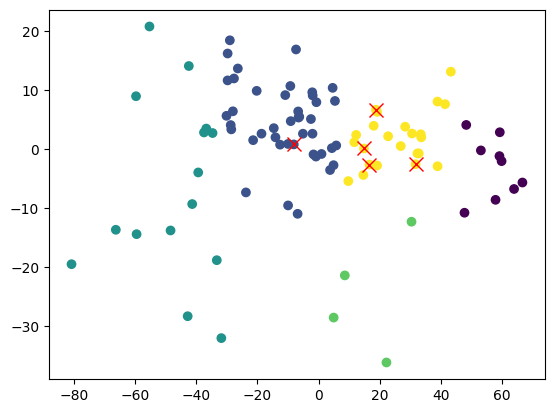

In [ ]:
target_team = 'LOUD'
target_team_id = team_df.loc[team_df['name'] == target_team, 'id'].head(1).values
if len(target_team_id) == 0:
    raise ValueError(f"No team found with name {target_team}")
target_team_id = target_team_id[0]
print(f"Found id {target_team_id} for {target_team}")
target_team_players = player_df.loc[player_df['home_team_id'] == target_team_id].drop_duplicates(subset='id').sort_values(by='updated_at').head()
target_team_player_ids = target_team_players.loc[:, 'id'].values
target_team_player_idx = df.index[df['id'].isin(target_team_player_ids)].values
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=prop, cmap='viridis')
for i in target_team_player_idx:
    plt.plot(reduced_data[i, 0], reduced_data[i, 1], 'rx', markersize=10)


In [ ]:
for c in df.columns:
    print(c)

id
ROUND_NUMBER
OUTCOME
SIDE
KILLS
DEATHS
ASSISTS
COMBAT_SCORE
KILLS_STINGER
KILLS_BUCKY
KILLS_JUDGE
KILLS_SPECTRE
KILLS_BULLDOG
KILLS_GUARDIAN
KILLS_PHANTOM
KILLS_VANDAL
KILLS_MARSHAL
KILLS_OUTLAW
KILLS_OPERATOR
KILLS_ARES
KILLS_ODIN
KILLS_CLASSIC
KILLS_SHORTY
KILLS_FRENZY
KILLS_GHOST
KILLS_SHERIFF
KILLS_MELEE
TIME_ALIVE
DEAD
DAMAGE_TAKEN
DAMAGE_DONE
SPIKE_CARRY_PERCENT
SPIKE_PLANT


In [ ]:
df.head().values

array([['106230274512017155', 22.12, 0.04145046684369608,
        0.09746797498279529, 0.6214918093318417, 0.6480564895993015,
        0.348690367919423, 179.8489498681685, 0.0, 0.003333333333333333,
        0.004675324675324675, 0.056023585876291485, 0.0,
        0.0035573122529644267, 0.3206919634559962, 0.1170974077357709,
        0.002, 0.0, 0.005, 0.0, 0.0, 0.018398804094456267,
        0.0017391304347826085, 0.043811663740456315, 0.02441350018268177,
        0.01711341991341991, 0.0, 132.3088541284999, 0.6464564895993016,
        96.53527042649799, 90.72015555128381, 0.16880949015900287,
        0.15867484432903065],
       ['106230271915475632', 22.12, 0.04145046684369608,
        0.09746797498279529, 0.8932324901015437, 0.6797162527194766,
        0.13170685517127165, 253.32634735540032, 0.0, 0.0,
        0.006877591973244147, 0.019356304394667564, 0.008666666666666666,
        0.011388703084355259, 0.03235865583691671, 0.3747842038519653,
        0.014315789473684209, 0.0, 0.1

In [ ]:
player_df.loc[player_df['id'] == '106230274512017155']

id  handle first_name last_name  status  \
400   106230274512017155  Mistic      James    Orfila  active   
677   106230274512017155  Mistic      James    Orfila  active   
1761  106230274512017155  Mistic     James     Orfila  active   
1784  106230274512017155  Mistic      James    Orfila  active   
1941  106230274512017155  Mistic      James    Orfila  active   
2010  106230274512017155  Mistic      James    Orfila  active   
2185  106230274512017155  Mistic      James    Orfila  active   

                                              photo_url        home_team_id  \
400   http://static.lolesports.com/players/170934348...  105680883461219195   
677                                                None  105680883461219195   
1761                                               None  105680972836508184   
1784  http://static.lolesports.com/players/170934348...  105680883461219195   
1941                                               None  105680972836508184   
2010                                               None  105680972836508184   
2185                                               None  105680972836508184   

                created_at            updated_at  
400   2024-04-10T08:30:21Z  2024-04-10T08:30:21Z  
677   2023-11-28T13:17:11Z  2024-03-02T01:38:12Z  
1761  2022-08-31T14:20:23Z  2022-08-31T14:20:23Z  
1784  2024-03-02T01:38:12Z  2024-04-10T08:30:21Z  
1941  2022-08-31T14:20:23Z  2023-01-11T06:10:50Z  
2010  2021-11-17T18:56:14Z  2022-08-31T14:20:23Z  
2185  2021-05-13T22:37:14Z  2021-10-07T10:39:05Z

In [ ]:
team_df.loc[team_df['id'] == '105680883461219195']

id acronym      home_league_id  \
1    105680883461219195      TL  106109559530232966   
68   105680883461219195      TL  107254585505459304   
102  105680883461219195      TL  106109559530232966   
110  105680883461219195      TL  106109559530232966   
159  105680883461219195      TL  107254585505459304   

                                         dark_logo_url  \
1    http://static.lolesports.com/teams/16372525869...   
68   http://static.lolesports.com/teams/16372525869...   
102  http://static.lolesports.com/teams/16256731638...   
110                                               None   
159  http://static.lolesports.com/teams/16256731638...   

                                        light_logo_url         slug  \
1    http://static.lolesports.com/teams/16372525869...  team-liquid   
68   http://static.lolesports.com/teams/16372525869...  team-liquid   
102  http://static.lolesports.com/teams/16256731638...  team-liquid   
110      http://static.lolesports.com/teams/liquid.png  team-liquid   
159  http://static.lolesports.com/teams/16256731638...  team-liquid   

            name  
1    Team Liquid  
68   Team Liquid  
102  Team Liquid  
110  Team Liquid  
159  Team Liquid